In [3]:
import torch as th
import numpy as np
import time
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
import torch as th
import os
import copy
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
import sys
sys.path.insert(0, '../../sample_scripts/')
import glob
import warnings
warnings.filterwarnings("ignore")

# from sample_scripts.sample_utils.inference_utils import to_tensor
from sample_scripts.sample_utils.vis_utils import plot_image
from sample_scripts.sample_utils import (
    ckpt_utils, 
    file_utils,
    params_utils,
)
from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

ckpt_loader = ckpt_utils.CkptLoader(log_dir="Masked_Face_woclip+BgNoHead+shadow_256", cfg_name="Masked_Face_woclip+BgNoHead+shadow_256.yaml")
cfg = ckpt_loader.cfg
# cfg.img_cond_model.in_image = cfg.img_cond_model.in_image
# cfg.img_cond_model.prep_image = [None, 'dilate=5', None]
cfg.img_model.image_size = 256
# Load dataset
dataset = 'ffhq'
set_ = 'valid'
img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
# Load dataset
if dataset == 'itw':
    cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
    img_dataset_path = f"/data/mint/DPM_Dataset/ITW/itw_images_aligned/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ITW/params/"
    img_ext = '.png'
    cfg.dataset.training_data = 'ITW'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/itw_images_aligned/'
elif dataset == 'ffhq':
    cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
    img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
    img_ext = '.jpg'
    cfg.dataset.training_data = 'ffhq_256_with_anno'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/ffhq_256/'
elif dataset in ['mp_valid', 'mp_test', 'mp_test2']:
    if dataset == 'mp_test':
        sub_f = '/MultiPIE_testset/'
    elif dataset == 'mp_test2':
        sub_f = '/MultiPIE_testset2/'
    elif dataset == 'mp_valid':
        sub_f = '/MultiPIE_validset/'
    else: raise ValueError
    img_dataset_path = f"/data/mint/DPM_Dataset/MultiPIE/{sub_f}/mp_aligned/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/MultiPIE/{sub_f}/params/"
    img_ext = '.png'
    cfg.dataset.training_data = f'/MultiPIE/{sub_f}/'
    cfg.dataset.root_path = f'/data/mint/DPM_Dataset/'
    cfg.dataset.data_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/mp_aligned/'
else: raise ValueError

cfg.dataset.deca_dir = f'{cfg.dataset.root_path}/{cfg.dataset.training_data}/params/'
cfg.dataset.face_segment_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/face_segment/"
cfg.dataset.deca_rendered_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/rendered_images/"
cfg.dataset.laplacian_mask_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/eyes_segment/"
cfg.dataset.laplacian_dir = f"{cfg.dataset.root_path}/{cfg.dataset.training_data}/laplacian/"

loader, dataset, _ = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector + ['albedo'],
    rmv_params=cfg.param_model.rmv_params,
    set_='valid',
    cfg=cfg,
)

from importlib import reload
sys.path.insert(0, '../../sample_scripts/cond_utils/DECA/')
from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.config import cfg as deca_cfg
from decalib.utils.tensor_cropper import transform_points

f_mask = np.load('./FLAME_masks_face-id.pkl', allow_pickle=True, encoding='latin1')
v_mask = np.load('./FLAME_masks.pkl', allow_pickle=True, encoding='latin1')
img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
mask={
    'v_mask':v_mask['face'].tolist(),
    'f_mask':f_mask['face'].tolist()
}

deca_cfg.model.extract_tex = True
deca_cfg.rasterizer_type = 'standard'
deca_cfg.model.use_tex = True 
deca = DECA(config = deca_cfg, device='cuda', mode='shape', mask=mask)

print(deca)

img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/valid/")
img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60065.jpg'])

dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=1,
                                    shuffle=False, num_workers=24)
os.makedirs('./output', exist_ok=True)
import tqdm
# for _ in tqdm.tqdm(range(len(img_path))):
subset_loader = iter(subset_loader)
t = tqdm.trange(len(subset_loader), desc="Generate the shadow mask...")
for _ in t:
    _, model_kwargs = next(subset_loader)

[#] Model Path : 
#0 : /data/mint/model_logs_mount/ist-cluster-figure/Masked_Face_woclip+BgNoHead+shadow_256/
[#] Config Path :  ['/home/mint/guided-diffusion/config/CVPRs/High_Resolution_V100/Masked_Face_woclip+BgNoHead+shadow_256.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/CVPRs/High_Resolution_V100/Masked_Face_woclip+BgNoHead+shadow_256.yaml')



Loading deca params...: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


[#] Bounding the input of UNet to +-1.0
[#] Parameters Conditioning
Params keys order :  ['shape', 'pose', 'exp', 'cam', 'faceemb', 'shadow']
Remove keys :  []
Input Image :  ['raw']
Image condition :  ['deca_masked_face_images_woclip', 'faceseg_nohead']
DPM Image condition :  [None]
creating the FLAME Decoder
trained model found. load /home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/data/deca_model.tar
[#] DECA : SRenderY applied mask
DECA(
  (E_flame): ResnetEncoder(
    (encoder): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momen

Generate the shadow mask...: 100%|██████████| 1/1 [00:00<00:00, 29.18it/s]


torch.Size([1, 3, 256, 256])


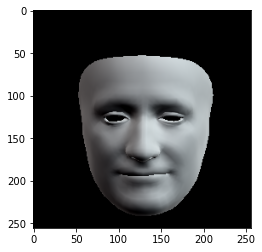

In [9]:
s_e = [0, 1]
img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/{set_}/")
img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=['60065.jpg'])
# if s_e is None:
#     img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=[name.split('/')[-1] for name in img_path])
# else:
#     img_idx = file_utils.search_index_from_listpath(list_path=img_path, search=[name.split('/')[-1] for name in img_path][s_e[0]:s_e[1]])

dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=1,
                                    shuffle=False, num_workers=24)
os.makedirs(f'./output/{set_}', exist_ok=True)
import tqdm
subset_loader = iter(subset_loader)
_, model_kwargs = next(subset_loader)
each_img_name = model_kwargs['image_name'][0]
cond = copy.deepcopy(model_kwargs)
rendered_image, orig_visdict = params_utils.render_deca(deca_params=cond, 
                                                        idx=0, n=1, 
                                                        useTex=True, extractTex=True, 
                                                        deca_mode='', use_detail=True, mask=mask, repeat=False, 
                                                        deca_obj=deca)
print(rendered_image.shape)
rendered_image = rendered_image.permute(0, 2, 3, 1).cpu().numpy()
plt.imshow(np.clip(rendered_image[0], 0, 255))
